In [261]:
import pandas as pd
import numpy as np
from rdkit import Chem
from mordred import Calculator, descriptors
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [262]:
targets = ["target_CHEMBL240"]
methods = ["RF"]
sorting_vars = ["logp"] #, "pchembl"]

# Initialize a Mordred descriptor calculator
calculator = Calculator(descriptors, ignore_3D=True)

# Function to compute Mordred descriptors for a given SMILES string
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return calculator(mol)
    else:
        return pd.Series([np.nan] * len(calculator.descriptors))
    
pca = PCA(n_components=2)

In [263]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [264]:
from sklearn.feature_selection import VarianceThreshold
from itertools import compress

def fs_variance(df, threshold:float=0.05):
    """
    Return a list of selected variables based on the threshold.
    """

    # The list of columns in the data frame
    features = list(df.columns)
    
    # Initialize and fit the method
    vt = VarianceThreshold(threshold = threshold)
    _ = vt.fit(df)
    
    # Get which column names which pass the threshold
    feat_select = list(compress(features, vt.get_support()))
    
    return feat_select

def get_pairwise_correlation(population_df, method="pearson"):
    """Given a population dataframe, calculate all pairwise correlations.
    Parameters
    ----------
    population_df : pandas.core.frame.DataFrame
        Includes metadata and observation features.
    method : str, default "pearson"
        Which correlation matrix to use to test cutoff.
    Returns
    -------
    list of str
        Features to exclude from the population_df.
    """


    # Get a symmetrical correlation matrix
    data_cor_df = population_df.corr(method=method)

    # Create a copy of the dataframe to generate upper triangle of zeros
    data_cor_natri_df = data_cor_df.copy()

    # Replace upper triangle in correlation matrix with NaN
    data_cor_natri_df = data_cor_natri_df.where(
        np.tril(np.ones(data_cor_natri_df.shape), k=-1).astype(np.bool)
    )

    # Acquire pairwise correlations in a long format
    # Note that we are using the NaN upper triangle DataFrame
    pairwise_df = data_cor_natri_df.stack().reset_index()
    pairwise_df.columns = ["pair_a", "pair_b", "correlation"]

    return data_cor_df, pairwise_df

def determine_high_cor_pair(correlation_row, sorted_correlation_pairs):
    """
    Select highest correlated variable given a correlation row with columns:
    ["pair_a", "pair_b", "correlation"]
    For use in a pandas.apply()
    """

    pair_a = correlation_row["pair_a"]
    pair_b = correlation_row["pair_b"]

    if sorted_correlation_pairs.get_loc(pair_a) > sorted_correlation_pairs.get_loc(pair_b):
        return pair_a
    
    else:
        return pair_b



sortedFCV
target_CHEMBL240
RF
logp
818


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


446
173


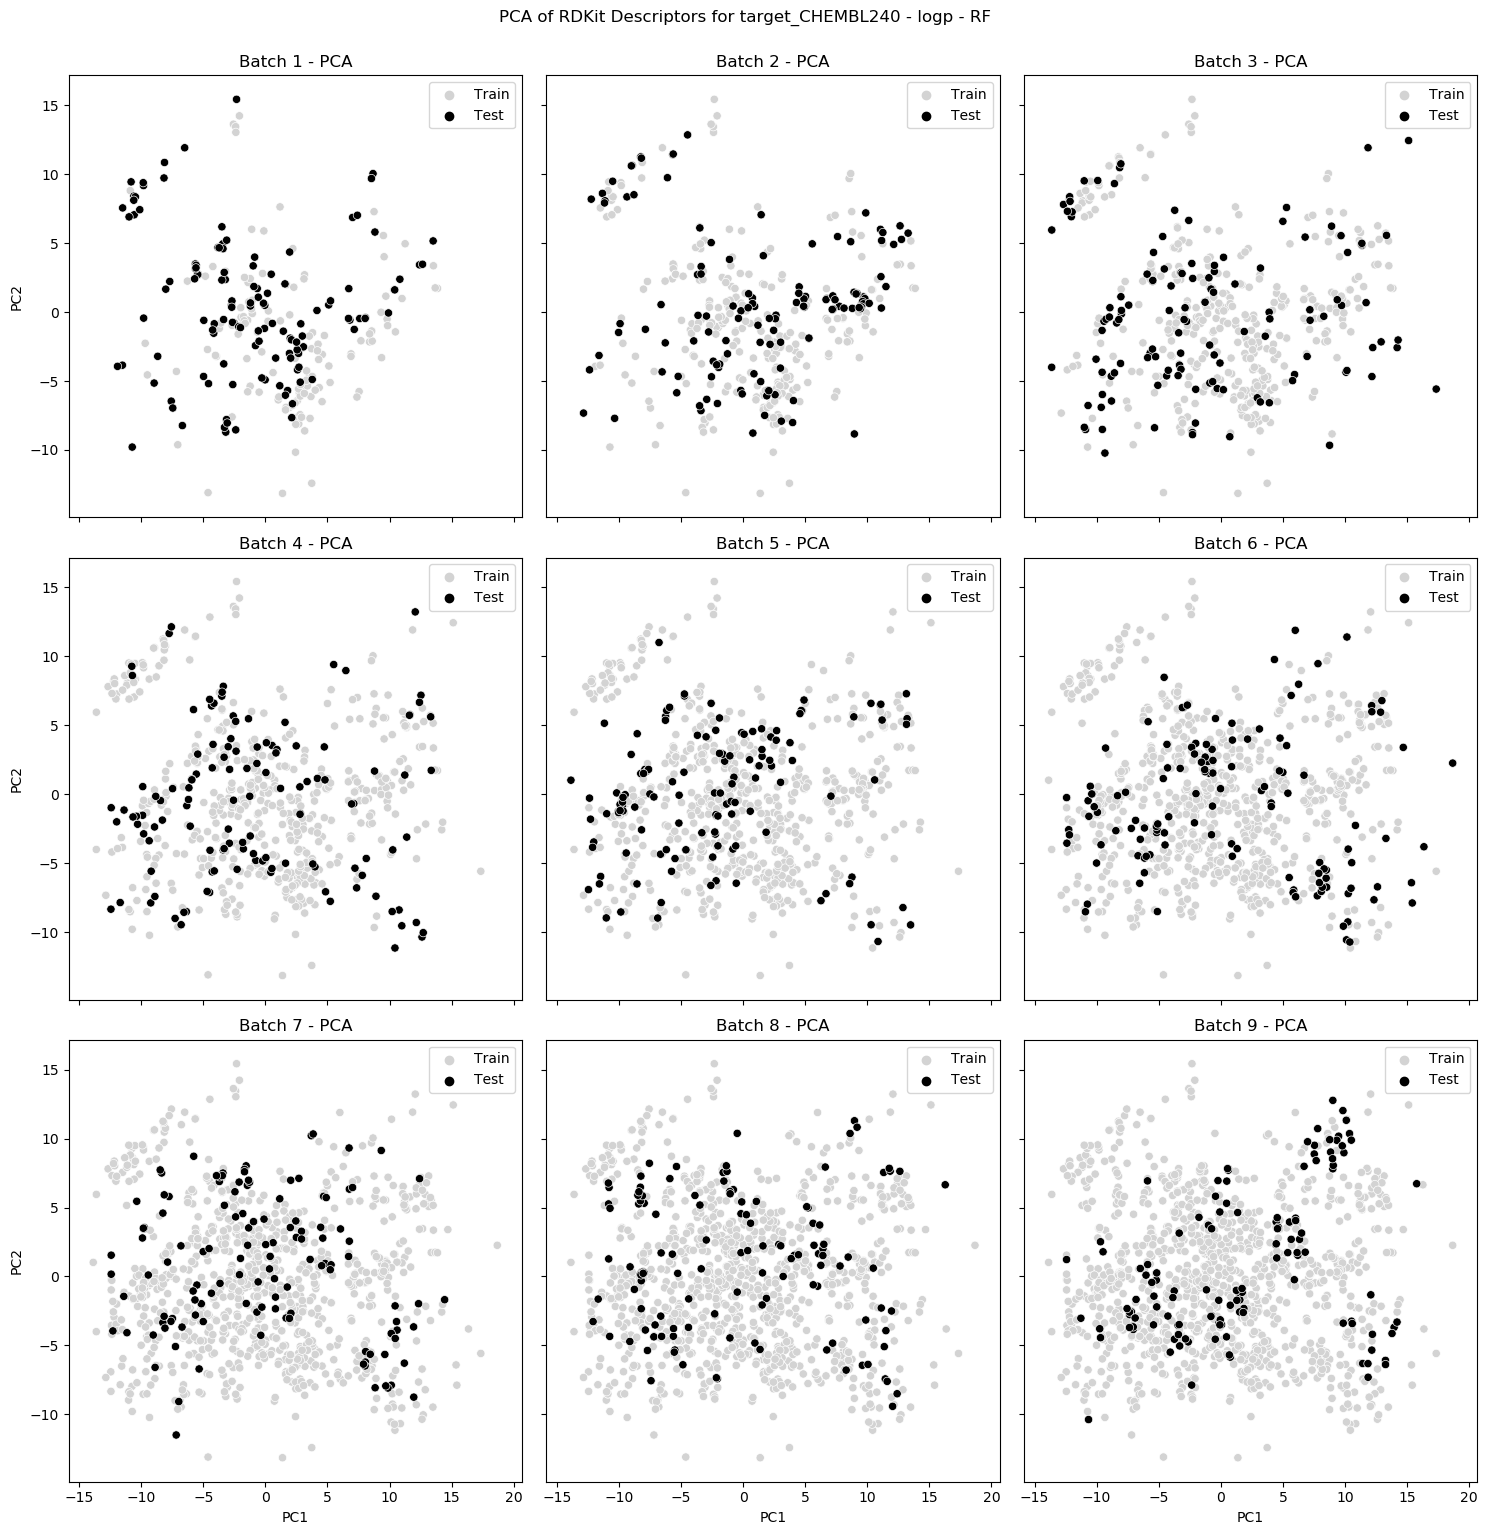

Explained variance by PC1: 0.21
Explained variance by PC2: 0.12


In [266]:
# Loop through each configuration
for target in targets:
    for var in sorting_vars:
        for method in methods:
            print("sortedFCV")
            print(target)
            print(method)
            print(var)

            # Load the DataFrame from a CSV file
            test_df = pd.read_csv(f"../{target}-1_results/{var}_sorted_fcv_results_{method}_testing batches.csv")
            train_df = pd.read_csv(f"../{target}-1_results/{var}_sorted_fcv_results_{method}_training batches.csv")
            
            # Combine training and testing data
            train_df['Set'] = 'Train'
            train_df = train_df.rename({'training batch': 'batch'}, axis=1)
            test_df['Set'] = 'Test'
            test_df = test_df.rename({'testing batch': 'batch'}, axis=1)
            combined_df = pd.concat([train_df, test_df], ignore_index=True)

            # Compute Mordred descriptors for unique molecules
            unique_smiles = combined_df['Standardized_SMILES'].drop_duplicates()
            unique_descriptors = unique_smiles.parallel_apply(lambda x: pd.Series(compute_descriptors(x)))
            unique_descriptors_df = pd.DataFrame(unique_descriptors)
            unique_descriptors_df['Standardized_SMILES'] = unique_smiles.values

            #Drop columns with any NaN values
            unique_descriptors_df = unique_descriptors_df.dropna(axis=1)
            
            Mordred_table = unique_descriptors_df.drop(columns=["Standardized_SMILES"])
            Mordred_table = Mordred_table.apply(pd.to_numeric, errors='coerce')
            Mordred_table = Mordred_table.dropna(axis='columns')
            selected_Features = fs_variance(Mordred_table .iloc[:,:-1], threshold=0.05)
            print(len(selected_Features))
            new_Mordred_table = Mordred_table [selected_Features]
            # Get correlation matrix and lower triangle of pairwise correlations in long format
            data_cor_df, pairwise_df = get_pairwise_correlation(population_df=new_Mordred_table)
            # Get absolute sum of correlation across features
            # The lower the index, the less correlation to the full data frame
            # We want to drop features with highest correlation, so drop higher index
            variable_cor_sum = data_cor_df.abs().sum().sort_values().index
            # And subset to only variable combinations that pass the threshold
            pairwise_df = pairwise_df.query("correlation > 0.95")
            excluded = pairwise_df.apply(lambda x: determine_high_cor_pair(x, variable_cor_sum), axis="columns")
            excluded_features = list(set(excluded.tolist()))
            print(len(excluded_features))
            new_Mordred_table = new_Mordred_table.drop(excluded_features, axis=1)

            max_feature_values = new_Mordred_table.max().abs()
            min_feature_values = new_Mordred_table.min().abs()

            outlier_features = max_feature_values[(max_feature_values > 15) | (min_feature_values > 15)].index.tolist()
            print(len(outlier_features))
            new_Mordred_table = new_Mordred_table.drop(outlier_features, axis=1)
            new_Mordred_table

            pca_result = pca.fit_transform(new_Mordred_table)
            pca_result

            # Create a DataFrame with PCA results
            pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
            pca_df['Standardized_SMILES'] = unique_smiles.values

            # Merge PCA results back to the combined dataframe to retain batch and set information
            merged_df = pd.merge(combined_df, pca_df, on='Standardized_SMILES', how='inner')

            # Get unique batches
            unique_batches = combined_df['batch'].dropna().unique()

            # Create a figure for subplots
            fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15), sharex=True, sharey=True)
            axes = axes.flatten()

            for i, batch in enumerate(unique_batches):
                if i >= len(axes):
                    break
                # Filter data for the current batch
                batch_df = merged_df[merged_df['batch'] == batch].sort_values(by='Set', ascending=False)

                # Plot PCA for the current batch
                sns.scatterplot(ax=axes[i], x='PC1', y='PC2', hue='Set', data=batch_df, palette=['lightgrey', 'black'])
                axes[i].set_title(f'Batch {batch} - PCA')
                axes[i].set_xlabel('PC1')
                axes[i].set_ylabel('PC2')
                axes[i].legend()

            # Adjust layout
            plt.tight_layout()
            plt.suptitle(f'PCA of RDKit Descriptors for {target} - {var} - {method}', y=1.02)
            plt.show()

            # Print explained variance for the PCA
            explained_variance = pca.explained_variance_ratio_
            print(f'Explained variance by PC1: {explained_variance[0]:.2f}')
            print(f'Explained variance by PC2: {explained_variance[1]:.2f}')

unsortedFCV
target_CHEMBL240
RF
logp
818


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


446
173


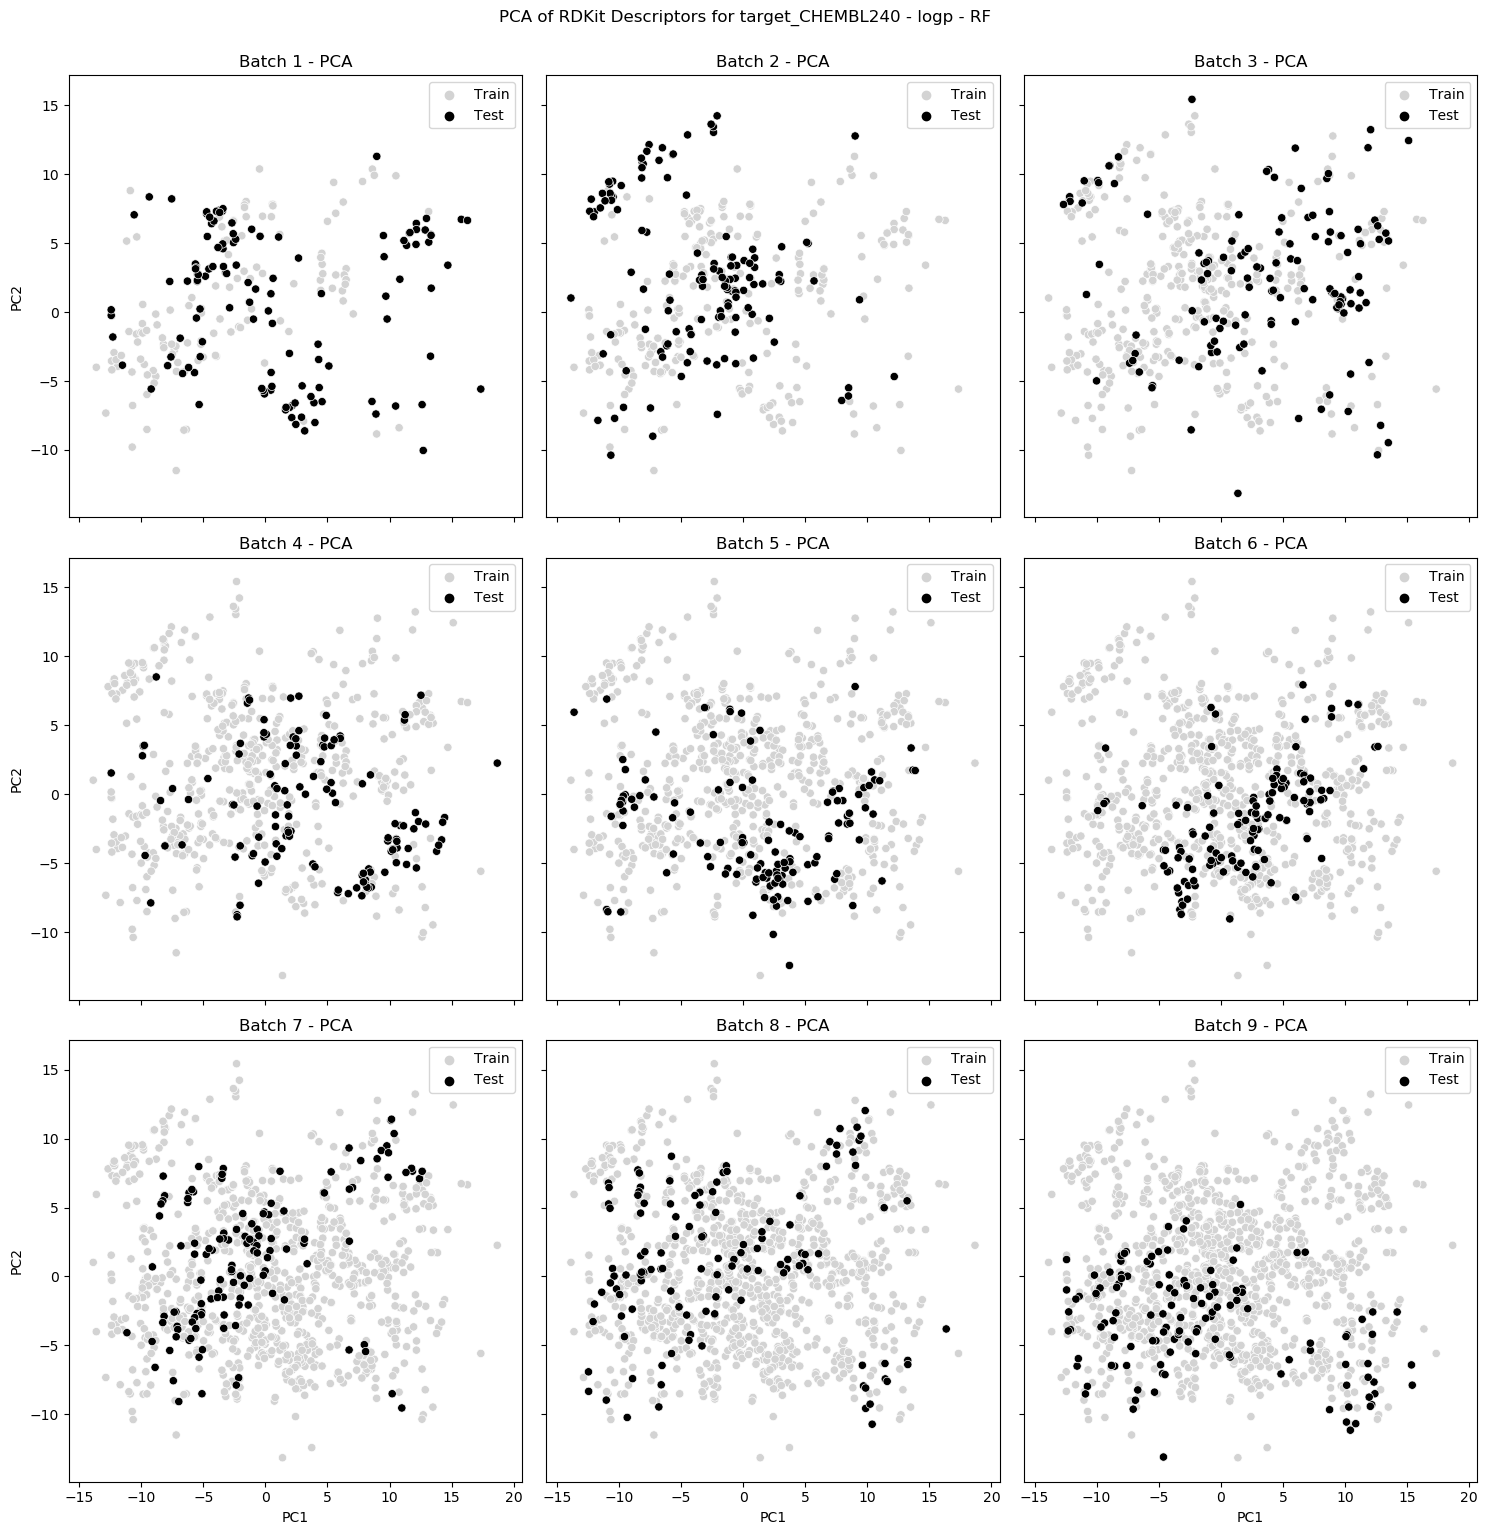

Explained variance by PC1: 0.21
Explained variance by PC2: 0.12


In [267]:
# Loop through each configuration
for target in targets:
    for var in sorting_vars:
        for method in methods:
            print("unsortedFCV")
            print(target)
            print(method)
            print(var)

            # Load the DataFrame from a CSV file
            test_df = pd.read_csv(f"../{target}-1_results/unsorted_fcv_results_{method}_testing batches.csv")
            train_df = pd.read_csv(f"../{target}-1_results/unsorted_fcv_results_{method}_training batches.csv")

            # Combine training and testing data
            train_df['Set'] = 'Train'
            train_df = train_df.rename({'training batch': 'batch'}, axis=1)
            test_df['Set'] = 'Test'
            test_df = test_df.rename({'testing batch': 'batch'}, axis=1)
            combined_df = pd.concat([train_df, test_df], ignore_index=True)

            # Compute Mordred descriptors for unique molecules
            unique_smiles = combined_df['Standardized_SMILES'].drop_duplicates()
            unique_descriptors = unique_smiles.parallel_apply(lambda x: pd.Series(compute_descriptors(x)))
            unique_descriptors_df = pd.DataFrame(unique_descriptors)
            unique_descriptors_df['Standardized_SMILES'] = unique_smiles.values

            #Drop columns with any NaN values
            unique_descriptors_df = unique_descriptors_df.dropna(axis=1)
            
            Mordred_table = unique_descriptors_df.drop(columns=["Standardized_SMILES"])
            Mordred_table = Mordred_table.apply(pd.to_numeric, errors='coerce')
            Mordred_table = Mordred_table.dropna(axis='columns')
            selected_Features = fs_variance(Mordred_table .iloc[:,:-1], threshold=0.05)
            print(len(selected_Features))
            new_Mordred_table = Mordred_table [selected_Features]
            # Get correlation matrix and lower triangle of pairwise correlations in long format
            data_cor_df, pairwise_df = get_pairwise_correlation(population_df=new_Mordred_table)
            # Get absolute sum of correlation across features
            # The lower the index, the less correlation to the full data frame
            # We want to drop features with highest correlation, so drop higher index
            variable_cor_sum = data_cor_df.abs().sum().sort_values().index
            # And subset to only variable combinations that pass the threshold
            pairwise_df = pairwise_df.query("correlation > 0.95")
            excluded = pairwise_df.apply(lambda x: determine_high_cor_pair(x, variable_cor_sum), axis="columns")
            excluded_features = list(set(excluded.tolist()))
            print(len(excluded_features))
            new_Mordred_table = new_Mordred_table.drop(excluded_features, axis=1)

            max_feature_values = new_Mordred_table.max().abs()
            min_feature_values = new_Mordred_table.min().abs()

            outlier_features = max_feature_values[(max_feature_values > 15) | (min_feature_values > 15)].index.tolist()
            print(len(outlier_features))
            new_Mordred_table = new_Mordred_table.drop(outlier_features, axis=1)
            new_Mordred_table

            pca_result = pca.fit_transform(new_Mordred_table)
            pca_result

            # Create a DataFrame with PCA results
            pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
            pca_df['Standardized_SMILES'] = unique_smiles.values

            # Merge PCA results back to the combined dataframe to retain batch and set information
            merged_df = pd.merge(combined_df, pca_df, on='Standardized_SMILES', how='inner')

            # Get unique batches
            unique_batches = combined_df['batch'].dropna().unique()

            # Create a figure for subplots
            fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15), sharex=True, sharey=True)
            axes = axes.flatten()

            for i, batch in enumerate(unique_batches):
                if i >= len(axes):
                    break

                # Filter data for the current batch
                batch_df = merged_df[merged_df['batch'] == batch].sort_values(by='Set', ascending=False)

                # Plot PCA for the current batch
                sns.scatterplot(ax=axes[i], x='PC1', y='PC2', hue='Set', data=batch_df, palette=['lightgrey', 'black'])
                axes[i].set_title(f'Batch {batch} - PCA')
                axes[i].set_xlabel('PC1')
                axes[i].set_ylabel('PC2')
                axes[i].legend()

            # Adjust layout
            plt.tight_layout()
            plt.suptitle(f'PCA of RDKit Descriptors for {target} - {var} - {method}', y=1.02)
            plt.show()

            # Print explained variance for the PCA
            explained_variance = pca.explained_variance_ratio_
            print(f'Explained variance by PC1: {explained_variance[0]:.2f}')
            print(f'Explained variance by PC2: {explained_variance[1]:.2f}')

CV
target_CHEMBL240
RF
logp
818


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


446
173


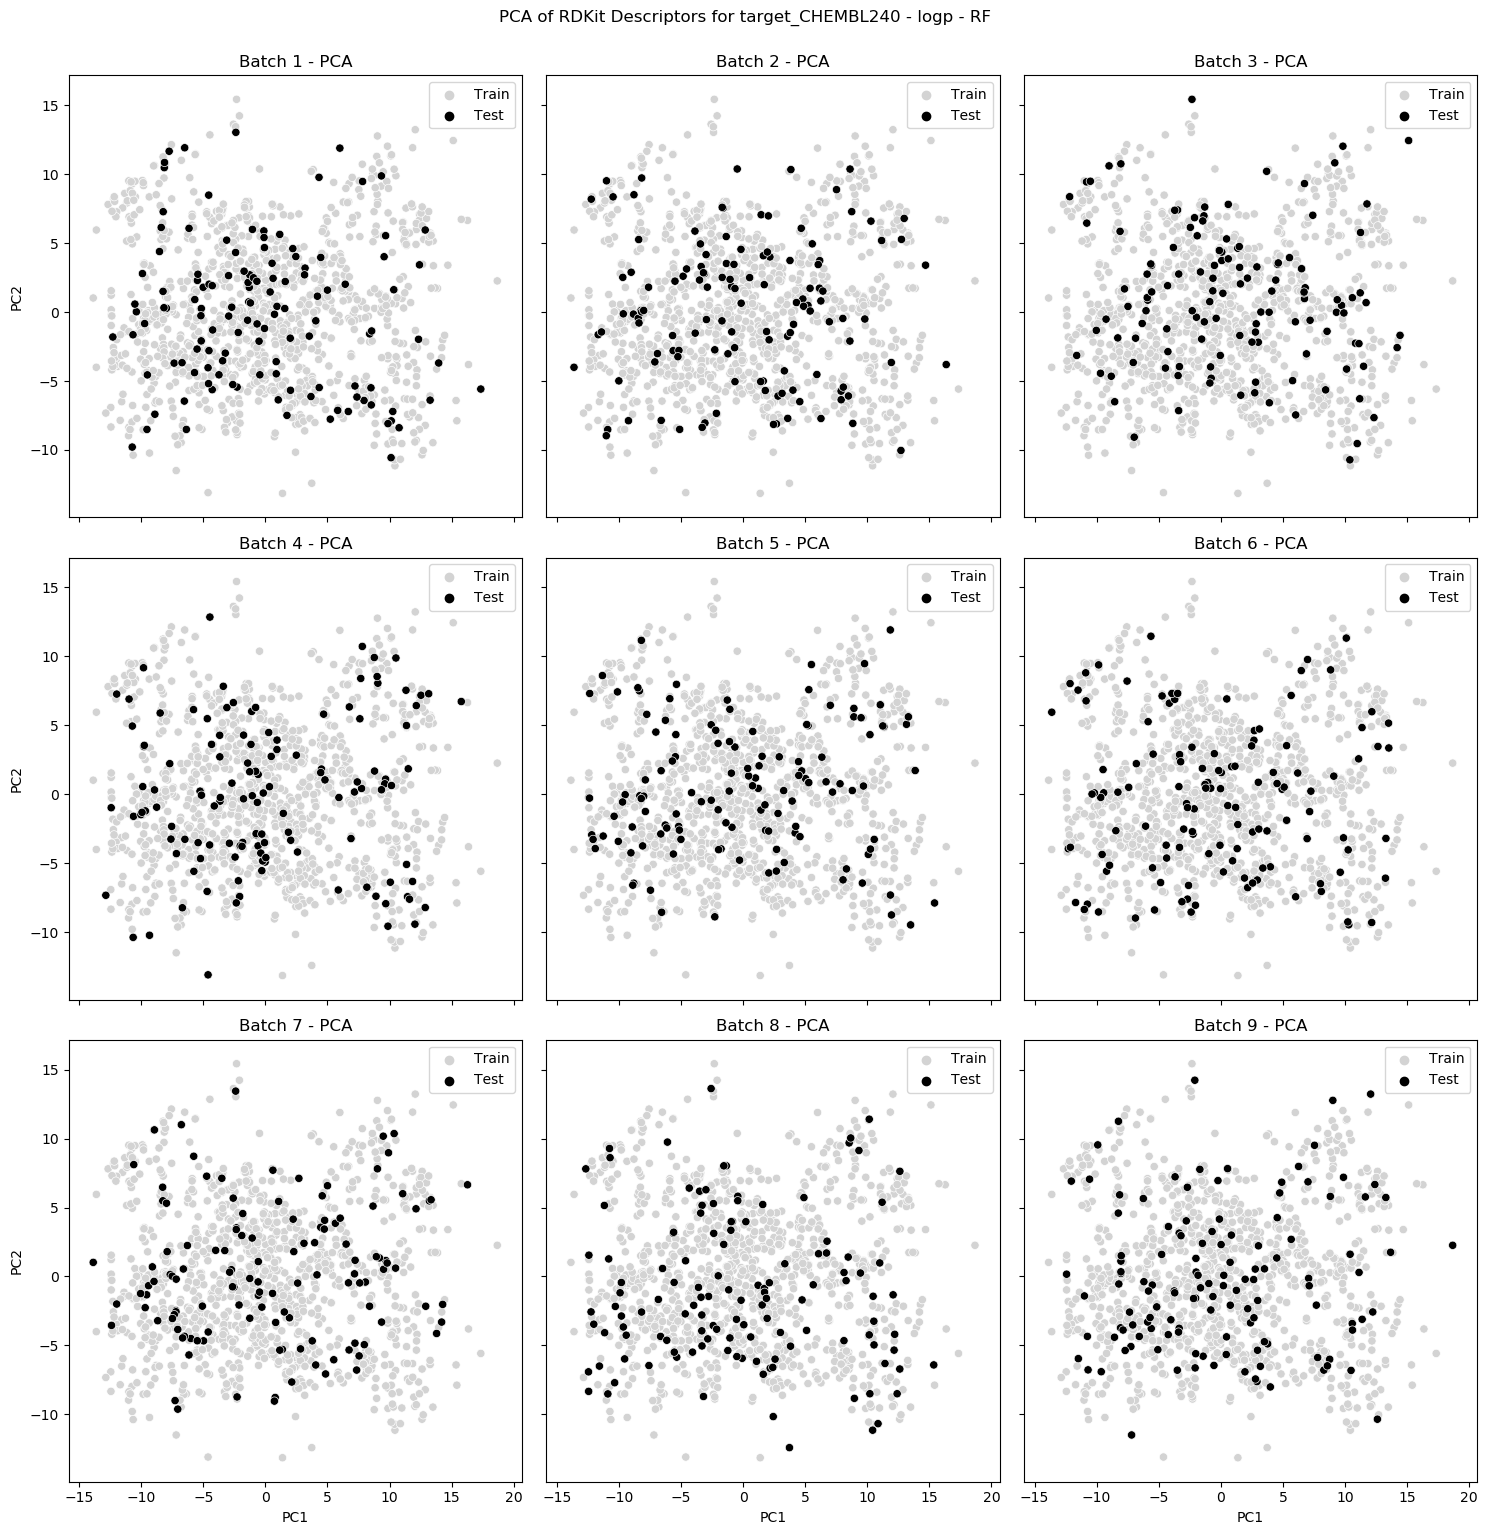

Explained variance by PC1: 0.21
Explained variance by PC2: 0.12


In [268]:
# Loop through each configuration
for target in targets:
    for var in sorting_vars:
        for method in methods:
            print("CV")
            print(target)
            print(method)
            print(var)

            # Load the DataFrame from a CSV file
            test_df = pd.read_csv(f"../{target}-1_results/cv_results_{method}_testing batches.csv")
            train_df = pd.read_csv(f"../{target}-1_results/cv_results_{method}_training batches.csv")

            # Combine training and testing data
            train_df['Set'] = 'Train'
            train_df = train_df.rename({'training batch': 'batch'}, axis=1)
            test_df['Set'] = 'Test'
            test_df = test_df.rename({'testing batch': 'batch'}, axis=1)
            combined_df = pd.concat([train_df, test_df], ignore_index=True)

            # Compute Mordred descriptors for unique molecules
            unique_smiles = combined_df['Standardized_SMILES'].drop_duplicates()
            unique_descriptors = unique_smiles.parallel_apply(lambda x: pd.Series(compute_descriptors(x)))
            unique_descriptors_df = pd.DataFrame(unique_descriptors)
            unique_descriptors_df['Standardized_SMILES'] = unique_smiles.values

            #Drop columns with any NaN values
            unique_descriptors_df = unique_descriptors_df.dropna(axis=1)
            
            Mordred_table = unique_descriptors_df.drop(columns=["Standardized_SMILES"])
            Mordred_table = Mordred_table.apply(pd.to_numeric, errors='coerce')
            Mordred_table = Mordred_table.dropna(axis='columns')
            selected_Features = fs_variance(Mordred_table .iloc[:,:-1], threshold=0.05)
            print(len(selected_Features))
            new_Mordred_table = Mordred_table [selected_Features]
            # Get correlation matrix and lower triangle of pairwise correlations in long format
            data_cor_df, pairwise_df = get_pairwise_correlation(population_df=new_Mordred_table)
            # Get absolute sum of correlation across features
            # The lower the index, the less correlation to the full data frame
            # We want to drop features with highest correlation, so drop higher index
            variable_cor_sum = data_cor_df.abs().sum().sort_values().index
            # And subset to only variable combinations that pass the threshold
            pairwise_df = pairwise_df.query("correlation > 0.95")
            excluded = pairwise_df.apply(lambda x: determine_high_cor_pair(x, variable_cor_sum), axis="columns")
            excluded_features = list(set(excluded.tolist()))
            print(len(excluded_features))
            new_Mordred_table = new_Mordred_table.drop(excluded_features, axis=1)

            max_feature_values = new_Mordred_table.max().abs()
            min_feature_values = new_Mordred_table.min().abs()

            outlier_features = max_feature_values[(max_feature_values > 15) | (min_feature_values > 15)].index.tolist()
            print(len(outlier_features))
            new_Mordred_table = new_Mordred_table.drop(outlier_features, axis=1)
            new_Mordred_table

            pca_result = pca.fit_transform(new_Mordred_table)
            pca_result

            # Create a DataFrame with PCA results
            pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
            pca_df['Standardized_SMILES'] = unique_smiles.values

            # Merge PCA results back to the combined dataframe to retain batch and set information
            merged_df = pd.merge(combined_df, pca_df, on='Standardized_SMILES', how='inner')

            # Get unique batches
            unique_batches = combined_df['batch'].dropna().unique()

            # Create a figure for subplots
            fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15), sharex=True, sharey=True)
            axes = axes.flatten()

            for i, batch in enumerate(unique_batches):
                if i >= len(axes):
                    break
                # Filter data for the current batch
                batch_df = merged_df[merged_df['batch'] == batch].sort_values(by='Set', ascending=False)

                # Plot PCA for the current batch
                sns.scatterplot(ax=axes[i], x='PC1', y='PC2', hue='Set', data=batch_df, palette=['lightgrey', 'black'])
                axes[i].set_title(f'Batch {batch} - PCA')
                axes[i].set_xlabel('PC1')
                axes[i].set_ylabel('PC2')
                axes[i].legend()

            # Adjust layout
            plt.tight_layout()
            plt.suptitle(f'PCA of RDKit Descriptors for {target} - {var} - {method}', y=1.02)
            plt.show()

            # Print explained variance for the PCA
            explained_variance = pca.explained_variance_ratio_
            print(f'Explained variance by PC1: {explained_variance[0]:.2f}')
            print(f'Explained variance by PC2: {explained_variance[1]:.2f}')

CV
target_CHEMBL240
RF
logp
818


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:44: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


446
173


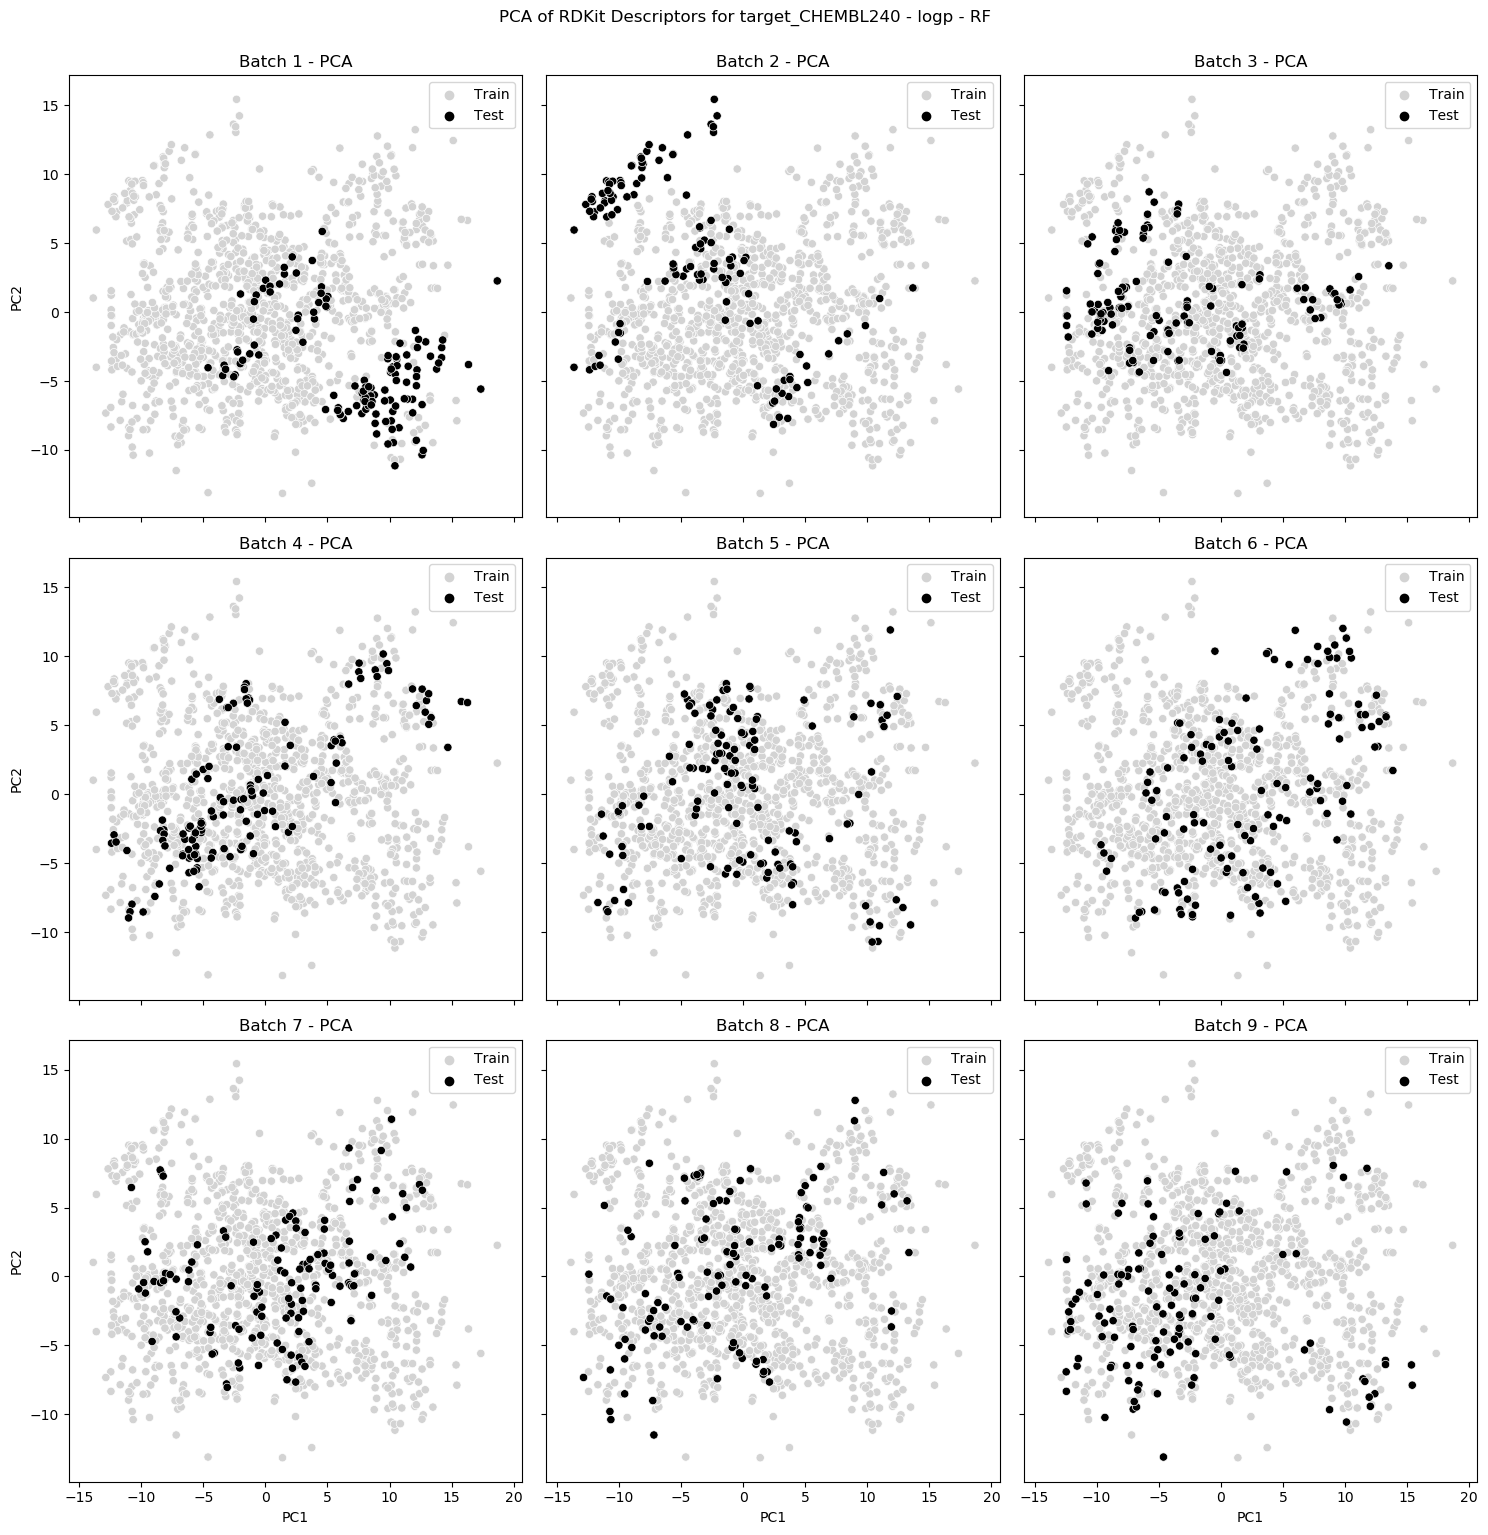

Explained variance by PC1: 0.21
Explained variance by PC2: 0.12


In [269]:
# Display the results DataFrame
results_df = pd.merge(test_df, results_df)
results_df

# Loop through each configuration
for target in targets:
    for var in sorting_vars:
        for method in methods:
            print("CV")
            print(target)
            print(method)
            print(var)

            # Load the DataFrame from a CSV file
            test_df = pd.read_csv(f"../{target}-1_results/scaffold_cv_results_{method}_testing batches.csv")
            train_df = pd.read_csv(f"../{target}-1_results/scaffold_cv_results_{method}_training batches.csv")

            # Combine training and testing data
            train_df['Set'] = 'Train'
            train_df = train_df.rename({'training batch': 'batch'}, axis=1)
            test_df['Set'] = 'Test'
            test_df = test_df.rename({'testing batch': 'batch'}, axis=1)
            combined_df = pd.concat([train_df, test_df], ignore_index=True)

            # Compute Mordred descriptors for unique molecules
            unique_smiles = combined_df['Standardized_SMILES'].drop_duplicates()
            unique_descriptors = unique_smiles.parallel_apply(lambda x: pd.Series(compute_descriptors(x)))
            unique_descriptors_df = pd.DataFrame(unique_descriptors)
            unique_descriptors_df['Standardized_SMILES'] = unique_smiles.values

            #Drop columns with any NaN values
            unique_descriptors_df = unique_descriptors_df.dropna(axis=1)
            
            Mordred_table = unique_descriptors_df.drop(columns=["Standardized_SMILES"])
            Mordred_table = Mordred_table.apply(pd.to_numeric, errors='coerce')
            Mordred_table = Mordred_table.dropna(axis='columns')
            selected_Features = fs_variance(Mordred_table .iloc[:,:-1], threshold=0.05)
            print(len(selected_Features))
            new_Mordred_table = Mordred_table [selected_Features]
            # Get correlation matrix and lower triangle of pairwise correlations in long format
            data_cor_df, pairwise_df = get_pairwise_correlation(population_df=new_Mordred_table)
            # Get absolute sum of correlation across features
            # The lower the index, the less correlation to the full data frame
            # We want to drop features with highest correlation, so drop higher index
            variable_cor_sum = data_cor_df.abs().sum().sort_values().index
            # And subset to only variable combinations that pass the threshold
            pairwise_df = pairwise_df.query("correlation > 0.95")
            excluded = pairwise_df.apply(lambda x: determine_high_cor_pair(x, variable_cor_sum), axis="columns")
            excluded_features = list(set(excluded.tolist()))
            print(len(excluded_features))
            new_Mordred_table = new_Mordred_table.drop(excluded_features, axis=1)

            max_feature_values = new_Mordred_table.max().abs()
            min_feature_values = new_Mordred_table.min().abs()

            outlier_features = max_feature_values[(max_feature_values > 15) | (min_feature_values > 15)].index.tolist()
            print(len(outlier_features))
            new_Mordred_table = new_Mordred_table.drop(outlier_features, axis=1)
            new_Mordred_table

            pca_result = pca.fit_transform(new_Mordred_table)
            pca_result

            # Create a DataFrame with PCA results
            pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
            pca_df['Standardized_SMILES'] = unique_smiles.values

            # Merge PCA results back to the combined dataframe to retain batch and set information
            merged_df = pd.merge(combined_df, pca_df, on='Standardized_SMILES', how='inner')

            # Get unique batches
            unique_batches = combined_df['batch'].dropna().unique()

            # Create a figure for subplots
            fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15), sharex=True, sharey=True)
            axes = axes.flatten()

            for i, batch in enumerate(unique_batches):
                if i >= len(axes):
                    break
                # Filter data for the current batch
                batch_df = merged_df[merged_df['batch'] == batch].sort_values(by='Set', ascending=False)

                # Plot PCA for the current batch
                sns.scatterplot(ax=axes[i], x='PC1', y='PC2', hue='Set', data=batch_df, palette=['lightgrey', 'black'])
                axes[i].set_title(f'Batch {batch} - PCA')
                axes[i].set_xlabel('PC1')
                axes[i].set_ylabel('PC2')
                axes[i].legend()

            # Adjust layout
            plt.tight_layout()
            plt.suptitle(f'PCA of RDKit Descriptors for {target} - {var} - {method}', y=1.02)
            plt.show()

            # Print explained variance for the PCA
            explained_variance = pca.explained_variance_ratio_
            print(f'Explained variance by PC1: {explained_variance[0]:.2f}')
            print(f'Explained variance by PC2: {explained_variance[1]:.2f}')